In [1]:
## Imports ##

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from menelaus.data_drift.cdbd import CDBD
from menelaus.data_drift.hdddm import HDDDM
from menelaus.data_drift import KdqTreeBatch
from menelaus.datasets import make_example_batch_data, fetch_rainfall_data

## Import Data ##
example_data = make_example_batch_data()

example_data.head()


,year,a,b,c,d,e,f,g,h,i,j,cat,confidence,drift
0,2007,5036.441154,198.936685,6995.029198,133187.697950,0.402750,-1.339692,90453.457231,8819.761759,5398.861764,1059.835492,2,0.591243,False
1,2007,10773.027107,179.260652,3467.970499,52174.100900,1.019491,-1.145258,72629.507052,10137.233887,7009.344647,1552.888540,2,0.196090,False
2,2007,6173.596856,199.775829,4921.472906,101848.950792,-2.248839,1.903668,54839.516587,9603.709193,10579.518133,856.266082,1,0.504019,False
3,2007,13208.612929,182.222072,9638.632797,92442.165726,-0.045599,1.106212,84447.758390,12511.305427,5618.433039,451.926312,2,0.487307,False
4,2007,2719.272009,213.028454,5501.439179,79155.846985,-1.602719,-1.368130,168769.099013,16034.259622,6214.909756,853.582074,1,0.211284,False


Synthetic Tax Data
- ``"Year"`` ranges from 2007-2021, with 20,000 observations each.
- Features ``"a"`` through ``"j"`` represent synthetic line items with either a normal or gamma distribution 
- ``"Cat"`` contains categorical variables ranging from 1-7, sampled with varying probability.
- ``"Confidence"`` simulates confidence scores from a model 

Drift is injected as follows:
- 2009: mean of ``"b"`` changes, reverts to original distribution in 2010 
- 2012: variances of ``"c"`` and ``"d"`` change, revert to original distribution in 2013
- 2015: correlation of ``"e"`` and ``"f"`` changes from 0 to 0.5, persists
- 2019: mean and variance of ``"h"`` change, persists
- 2021: mean and variance of ``"j"`` change, persists


## Data Drift Detection

### Hellinger Distance Drift Detection Method (HDDDM)

- batch-based
- unsupervised and detects changes in feature distributions 
- monitors continuous and categorical features
- uses the Hellinger distance metric to compare test and reference batches 
- capable of detecting gradual or abrupt changes in data.

In [2]:
# Set up reference and test data, using 2007 as reference year
# Test data will be batched by year
example_data = make_example_batch_data()
reference = example_data[example_data.year == 2007].iloc[:, 1:-2]
all_test = example_data[example_data.year != 2007]

#  Setup HDDDM
np.random.seed(1)
hdddm = HDDDM(subsets=8) #subsets parameter affects accuracy of detection on first batch, 
# too small, risk of FN. 
# too big, risk of FP

# Store epsilons per feature for heatmap
years = all_test.year.unique()
heatmap_data = pd.DataFrame(columns = years)

# Store drift for test statistic plot
detected_drift = []

# Run HDDDM, iterate thru each year and data
hdddm.set_reference(reference)
for year, subset_data in example_data[example_data.year != 2007].groupby("year"):
    hdddm.update(subset_data.iloc[:, 1:-2])
    heatmap_data[year] = hdddm.feature_epsilons
    detected_drift.append(hdddm.drift_state)

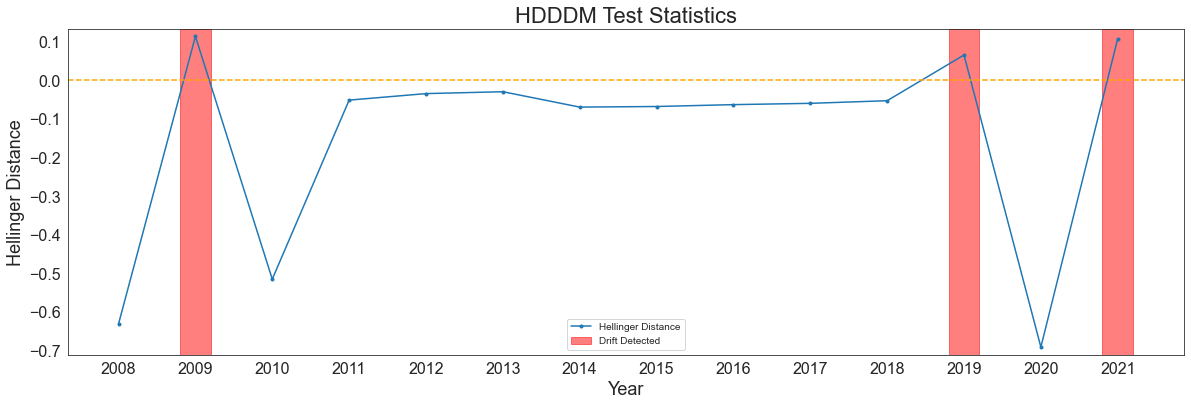

In [3]:
## Plot Line Graph ##
sns.set_style("white")
h_distances = [
    ep - th for ep, th in zip(hdddm.epsilon_values.values(), hdddm.thresholds.values())
]

# Plot Hellinger Distance against Year, along with detected drift
plot_data = pd.DataFrame(
    {"Year": years, "Hellinger Distance": h_distances, "Detected Drift": detected_drift}
)
sns.set_style("white")
plt.figure(figsize=(20, 6))
plt.plot(
    "Year", "Hellinger Distance", data=plot_data, label="Hellinger Distance", marker="."
)
plt.grid(False, axis="x")
plt.xticks(years, fontsize=16)
plt.yticks(fontsize=16)
plt.title("HDDDM Test Statistics", fontsize=22)
plt.ylabel("Hellinger Distance", fontsize=18)
plt.xlabel("Year", fontsize=18)
plt.ylim([min(h_distances) - 0.02, max(h_distances) + 0.02])
for _, t in enumerate(plot_data.loc[plot_data["Detected Drift"] == "drift"]["Year"]):
    plt.axvspan(
        t - 0.2, t + 0.2, alpha=0.5, color="red", label=("Drift Detected" if _ == 0 else None)
    )
plt.legend()
plt.axhline(y=0, color="orange", linestyle="dashed")

plt.show()

Drift is detected in:
- 2009 
- 2019 
- 2021 

Misses drift in:
- 2012 (change in variance)
- 2015 (change in correlation) 

 

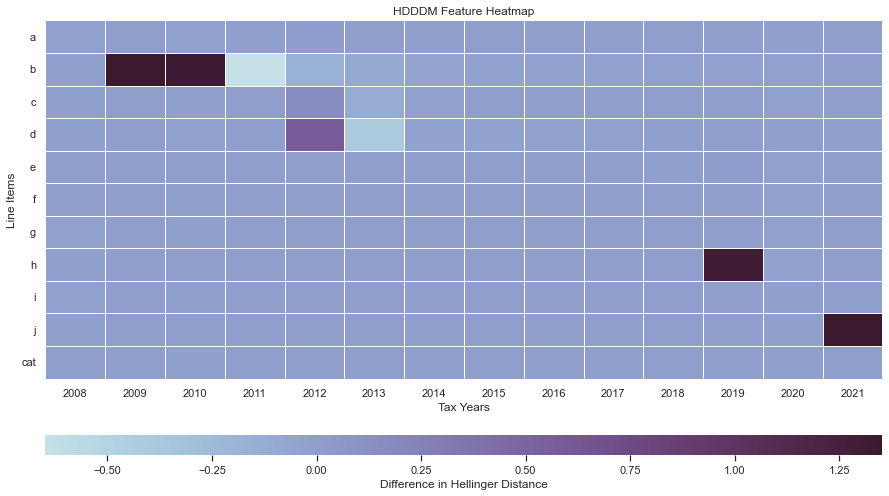

In [4]:
## Plot Heatmap ##
sns.set_style("whitegrid")
sns.set(rc={"figure.figsize": (15, 8)})

# Setup plot

# Setup plot
grid_kws = {"height_ratios": (0.9, 0.05), "hspace": 0.3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
coloring = sns.cubehelix_palette(start=0.8, rot=-0.5, as_cmap=True)
ax = sns.heatmap(
    heatmap_data,
    ax=ax,
    cmap=coloring,
    xticklabels=heatmap_data.columns,
    yticklabels=example_data.columns[1:-2],
    linewidths=0.5,
    cbar_ax=cbar_ax,
    cbar_kws={"orientation": "horizontal"},
)
ax.set_title('HDDDM Feature Heatmap')
ax.set(xlabel="Tax Years", ylabel="Line Items")
ax.collections[0].colorbar.set_label("Difference in Hellinger Distance")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()

- Drift in feature ``"B"`` is detected in 2009 and 2010 (as it reverts to normal).
- Missed drift but observes change in feature ``"D"`` in 2012 and 2013 (as it reverts to normal).
- Drift in feature ``"H"`` is detected in 2019. 
- Drift in feature ``"J"`` is detected in 2021.
- The undetected drift occurs in 2015 in the correlations between features ``"E"`` and ``"F"``.
 

### kdqTREE

- batch and streaming 
- unsupervised and detects changes in feature distributions 
- monitors only continuous features
- uses the Kullback-Leibler divergence metric to compare test and reference batches after partitioning the data space via a k-d-quad-tree (kdq-tree) 



In [5]:
## Setup ##

# kdq-Tree does use bootstrapping to define its critical thresholds, so setting
# the seed is important to reproduce exact behavior.
np.random.seed(123)

df = example_data

# Capture the column which tells us when drift truly occurred
drift_years = df.groupby("year")["drift"].apply(lambda x: x.unique()[0]).reset_index()

# Because the drift in 2009, 2012, and 2016 is intermittent - it reverts
# back to the prior distribution in the subsequent year - we should also detect
# drift in 2010, 2013, and 2016. So:
drift_years.loc[drift_years["year"].isin([2010, 2013, 2016]), "drift"] = True

# Cannot monitor categorical features
df.drop(columns=["cat", "confidence", "drift"], inplace=True)


kdq_plot_data = {}
status = pd.DataFrame(columns=["year", "drift","KL","threshold"])
det = KdqTreeBatch()

# Set up reference batch, using 2007 as reference year
det.set_reference(df[df.year == 2007].drop(columns=['year']))

# Batch the data by year and run kdqTree
for group, sub_df in df[df.year != 2007].groupby("year"):
    det.update(sub_df.drop(columns=["year"]))
    status = pd.concat(
        [status, pd.DataFrame({"year": [group], "drift": [det.drift_state],
        "KL":[det._test_dist],"threshold":[det._critical_dist]})],
        axis=0,
        ignore_index=True,
    )
    if det.drift_state is not None:
        # capture the visualization data
        kdq_plot_data[group] = det.to_plotly_dataframe()
        
        # option to specify reference batch to be any year 
        #det.set_reference(df[df.year == XXXX])


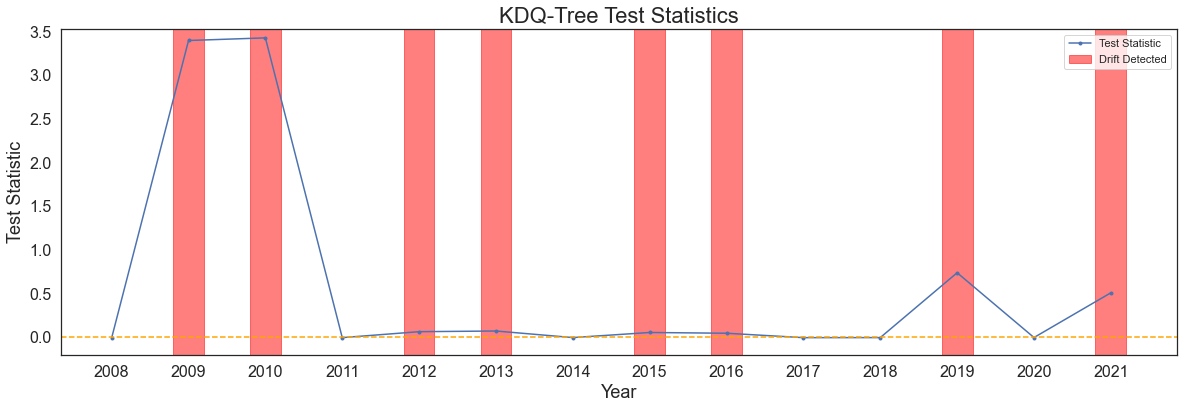

In [6]:
sns.set_style("white")
status['kdq_distances'] = status["KL"] - status["threshold"] 

# Plot test statistic against year, along with detected drift
sns.set_style("white")
plt.figure(figsize=(20, 6))
plt.plot(
    "year", "kdq_distances", data=status, label="Test Statistic", marker="."
)
plt.grid(False, axis="x")
plt.xticks(all_test.year.unique(), fontsize=16)
plt.yticks(fontsize=16)
plt.title("KDQ-Tree Test Statistics", fontsize=22)
plt.ylabel("Test Statistic", fontsize=18)
plt.xlabel("Year", fontsize=18)
plt.ylim([min(status['kdq_distances']) - 0.2, max(status['kdq_distances']) + 0.1])
for _, t in enumerate(status.loc[status["drift"] == "drift"]["year"]):
    plt.axvspan(
        t - 0.2, t + 0.2, alpha=0.5, color="red", label=("Drift Detected" if _ == 0 else None)
    )
plt.legend()
plt.axhline(y=0, color="orange", linestyle="dashed")
plt.show()

Drift is detected in every year:
- 2009 (mean of Line Item ``"B"``) and 2010, as it reverts to original distribution 
- 2012 (variance of Line Item ``"C"`` and ``"D"``) and 2013, as it reverts
- 2015 (change in correlation between Line Item ``"E"`` and ``"F"``) and 2016, as it reverts
- 2019 (change in mean and variance of Line Item ``"H"``)
- 2021 (change in mean and variance of Line Item ``"J"``)



 

In [7]:

fig = px.treemap(
    data_frame=kdq_plot_data[2012],
    names="name",
    ids="idx",
    parents="parent_idx",
    color="kss",
    color_continuous_scale="blues",
    title=year,
)
fig.update_traces(root_color="lightgrey")
fig.show()
#fig.write_html(f"example_kdqtree_treemap_{2012}.html")


Plot shows KDQ-Tree and Kulldorff Spatial Scan Statistic (KSS) for 2012. 
- Higher values of KSS indicate that a given region of the data space has greater divergence between the reference and test data.


## Concept Drift Detectors 

In [8]:
from menelaus.datasets import fetch_rainfall_data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from menelaus.concept_drift import LinearFourRates, ADWINAccuracy

# use streaming dataset
# read in data
df = fetch_rainfall_data()

df.head()


,temperature,dew_point,sea_level_pressure,visibility,average_wind_speed,max_sustained_wind_speed,minimum_temperature,maximum_temperature,rain
0,-1.475684,-1.281766,0.059493,-0.825958,0.789079,0.352826,-1.493780,-1.392642,0
1,-1.144666,-0.873399,-0.221453,-0.902082,1.062598,0.935369,-1.263850,-1.050214,0
2,-0.775818,-0.340531,-0.254999,-1.967823,1.855806,1.499119,-1.173682,-0.458302,1
3,-1.163582,-0.908260,-0.206777,-0.927457,3.196052,3.021245,-0.997854,-1.294805,1
4,-1.716855,-1.585551,-0.143878,-0.902082,1.937861,1.499119,-1.849944,-1.637234,0


### Rainfall Data

Weather measurements collected over a 50-year period in Bellevue, Nebraska. 
- 8 features
- Label: 0 (no rain) and 1 (rain) 
- Drift injected at index 12,000 and persists. 

In [9]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
     df.iloc[:,:-1], df.iloc[:,-1], test_size=0.5, 
     random_state=42,     shuffle = False
)
# apply classifier
clf = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)
print("Average accuracy of classifier: ",clf.score(X_test, y_test))

# get running accuracy from classifier to compare performance
acc_orig = np.cumsum(clf.predict(X_test) == y_test)
acc_orig = acc_orig / np.arange(1, 1 + len(acc_orig))

Average accuracy of classifier:  0.6700440528634362




### Adapative Windowing (ADWIN)

- streaming algorithm 
- monitors performance metric, accuracy, with user passing in true and predicted labels for each row in test data
- ADWIN monitors a running test statistic over multiple subwindows 
- if test statistic exceeds a threshold detects drift and recommends subwindow containing new concept to be used for training


In [10]:
X_test 

,temperature,dew_point,sea_level_pressure,visibility,average_wind_speed,max_sustained_wind_speed,minimum_temperature,maximum_temperature
9079,-0.331308,-0.245909,0.130778,0.493530,-0.496464,-0.586757,-0.411760,-0.179467
9080,-0.137426,0.102697,-0.030661,-1.485702,-0.441760,-0.962591,-0.136747,-0.223493
9081,0.245610,0.222219,-0.194197,0.036784,-0.988800,-0.586757,0.359179,0.314608
9082,0.042270,0.252099,-0.217260,0.265157,-1.317023,-1.319633,-0.046579,0.070017
9083,-0.246189,0.067836,-0.156458,-0.216963,0.269391,-0.417632,-0.542504,0.070017
...,...,...,...,...,...,...,...,...
18154,-0.888340,0.124489,-1.181205,1.472878,2.250786,-0.948261,-0.864324,-0.870394
18155,-0.714037,-0.039047,-1.181205,0.816431,0.935369,-0.217898,-1.040430,-0.671783
18156,-0.489933,-0.141782,-1.181205,-0.633224,-0.774674,0.025556,-0.688218,-0.430613
18157,-0.499893,-0.114526,-1.181205,-1.016152,-0.962591,-0.461353,-0.512112,-0.406969


In [11]:
adwin = ADWINAccuracy()

# Set up DF to record results.
status = pd.DataFrame(columns=["index", "y_true", "y_pred", "drift_detected"])
rec_list = []

# run ADWIN on test data
for i in range(len(X_train), len(df)):

     # Apply KNN model on test data
     x = X_test.loc[[i]]
     y_pred = int(clf.predict(x))
     y_true = int(y_test.loc[[i]])
     
     # Update ADWIN with true and predicted labels 
     adwin.update(y_true, y_pred)

     # Store results in dataset
     status.loc[i] = [i, y_true, y_pred, adwin.drift_state]
     
     # If drift is detected, get indexes for window and retrain.
     if adwin.drift_state == "drift":
          retrain_start = adwin.retraining_recs[0] + len(X_train)
          retrain_end = adwin.retraining_recs[1] + len(X_train)
          rec_list.append([retrain_start, retrain_end])

          # The retraining recommendations produced here 
          # correspond to the samples which belong to ADWIN's 
          # new, smaller window, after drift is detected.
          X_train_new = X_test.loc[retrain_start:retrain_end,]
          y_train_new = y_test.loc[retrain_start:retrain_end,]
          clf = KNeighborsClassifier(n_neighbors=10)
          clf.fit(X_train_new, y_train_new)

# Update status with accuracy from retraining 
status['original_accuracy'] = acc_orig
status['accuracy'] = np.cumsum(status.y_true == status.y_pred)
status['accuracy'] = status['accuracy'] / np.cumsum(np.repeat(1,    
     status.shape[0]))

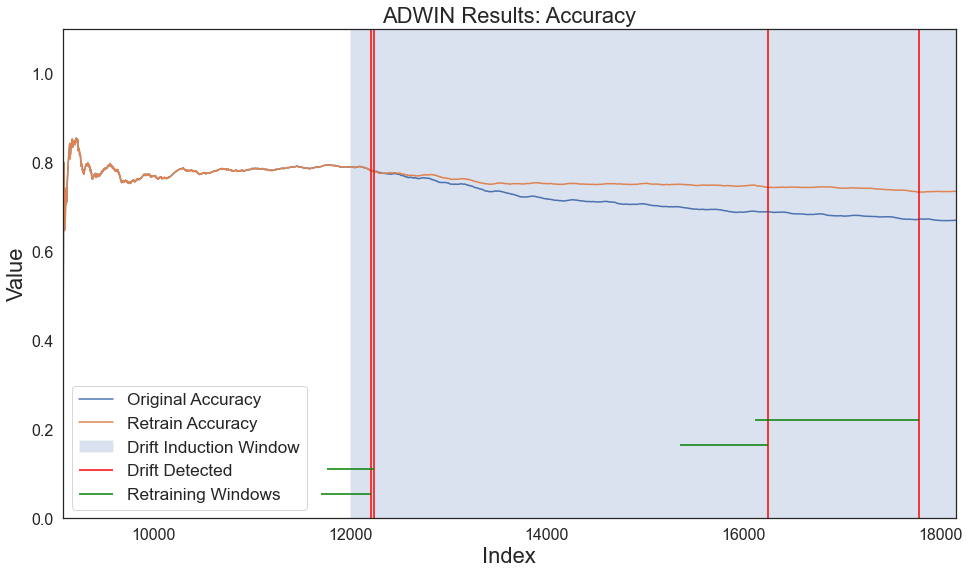

In [12]:
import matplotlib.pyplot as plt
## Plotting ##
plt.figure(figsize=(16, 9))
plt.plot("index", "original_accuracy", data=status, 
     label="Original Accuracy")
plt.plot("index", "accuracy", data=status, 
     label="Retrain Accuracy")
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("ADWIN Results: Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=22)
plt.xlabel("Index", fontsize=22)
ylims = [0, 1.1]
plt.ylim(ylims)
plt.xlim([len(X_train), len(df)])
plt.axvspan(12000, len(df), alpha=0.2, label="Drift Induction Window")
# Draw red lines that indicate where drift was detected
plt.vlines(
     x=status.loc[status["drift_detected"] == "drift"]["index"],
     ymin=ylims[0],
     ymax=ylims[1],
     label="Drift Detected",
     color="red",
)
# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
     start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
     stop=0.2 * ylims[1],
     num=len(rec_list),
)
# Draw green lines that indicate where retraining occurred
plt.hlines(
     y=rec_list["y_val"],
     xmin=rec_list[0],
     xmax=rec_list[1],
     color="green",
     label="Retraining Windows",
)
plt.legend(loc='lower left', fontsize='x-large')
plt.show()

### Linear Four Rates (LFR)

- streaming algorithm 
- monitors the four cells of the confusion matrix (TPR, FPR, TNR, FNR)
- if test statistic exceeds a threshold detects drift and recommends subwindow containing new concept to be used for training


In [13]:
# Set up LFR detector to detect at significance of .001. 5000 Monte Carlo
# simulations will be run every 10 samples to detect drift.

# Restart classifier 
clf = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)

# get running accuracy from classifier to compare performance
acc_orig = np.cumsum(clf.predict(X_test) == y_test)
acc_orig = acc_orig / np.arange(1, 1 + len(acc_orig))

lfr = LinearFourRates(
    time_decay_factor=0.6,
    warning_level=0.01,
    detect_level=0.001,
    num_mc=5000,
    burn_in=10,
    subsample=10,
)

# Set up DF to record results.
status = pd.DataFrame(columns=["index", "y_true", "y_pred", "drift_detected"])
rec_list = []

# Run LFR and retrain.
np.random.seed(123) 

for i in range(len(X_train), len(df)):

    # Apply KNN model on test data
    x = X_test.loc[[i]]
    y_pred = int(clf.predict(x))
    y_true = int(y_test.loc[[i]])
     
    lfr.update(y_true, y_pred)
    status.loc[i] = [i, y_true, y_pred, lfr.drift_state]

    # If drift is detected, examine the retraining recommendations and retrain.
    if lfr.drift_state == "drift":

        retrain_start = lfr.retraining_recs[0] + len(X_train)
        retrain_end = lfr.retraining_recs[1] + len(X_train)
        if (
            retrain_start == retrain_end
        ):  # minimum retraining window in case of sudden drift
            retrain_start = max(0, retrain_start - 300)
        rec_list.append([retrain_start, retrain_end])

        # If retraining is not desired, omit the next four lines.
        X_train_new = X_test.loc[retrain_start:retrain_end,]
        y_train_new = y_test.loc[retrain_start:retrain_end,]
        clf = KNeighborsClassifier(n_neighbors=10)
        clf.fit(X_train_new, y_train_new)

status['original_accuracy'] = acc_orig
status['accuracy'] = np.cumsum(status.y_true == status.y_pred)
status['accuracy'] = status['accuracy'] / np.arange(1, 1 + len(status))


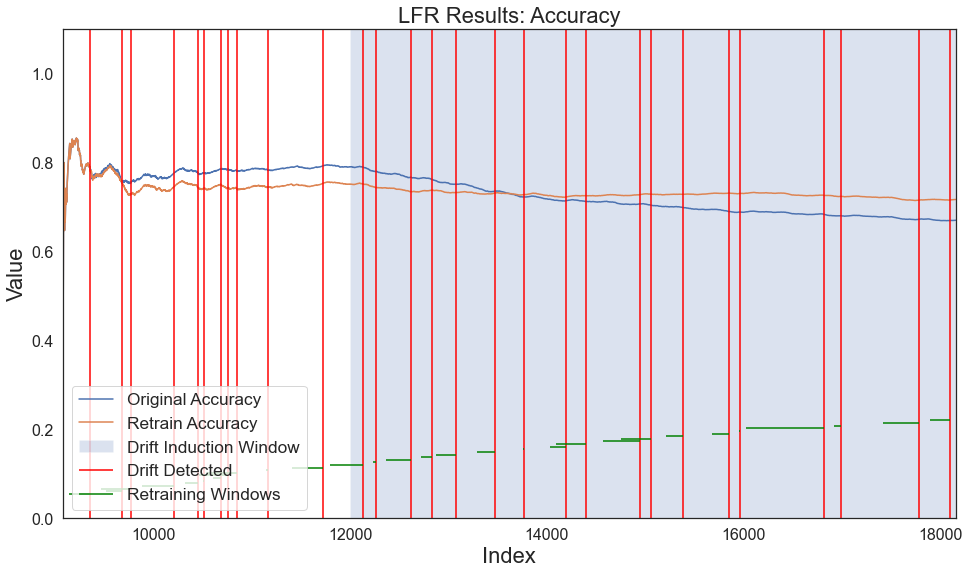

In [14]:
import matplotlib.pyplot as plt
## Plotting ##
plt.figure(figsize=(16, 9))
plt.plot("index", "original_accuracy", data=status, 
     label="Original Accuracy")
plt.plot("index", "accuracy", data=status, 
     label="Retrain Accuracy")
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("LFR Results: Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=22)
plt.xlabel("Index", fontsize=22)
ylims = [0, 1.1]
plt.ylim(ylims)
plt.xlim([len(X_train), len(df)])
plt.axvspan(12000, len(df), alpha=0.2, label="Drift Induction Window")
# Draw red lines that indicate where drift was detected
plt.vlines(
     x=status.loc[status["drift_detected"] == "drift"]["index"],
     ymin=ylims[0],
     ymax=ylims[1],
     label="Drift Detected",
     color="red",
)
# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
     start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
     stop=0.2 * ylims[1],
     num=len(rec_list),
)
# Draw green lines that indicate where retraining occurred
plt.hlines(
     y=rec_list["y_val"],
     xmin=rec_list[0],
     xmax=rec_list[1],
     color="green",
     label="Retraining Windows",
)
plt.legend(loc='lower left', fontsize='x-large')
plt.show()

## Ensemble Detector 

In [21]:
from menelaus.data_drift import KdqTreeStreaming
from menelaus.ensemble import StreamingEnsemble, BatchEnsemble
from menelaus.ensemble import SimpleMajorityElection, MinimumApprovalElection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from menelaus.concept_drift import ADWINAccuracy

df = fetch_rainfall_data()

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
     df.iloc[:,:-1], df.iloc[:,-1], test_size=0.5, 
     random_state=42,     shuffle = False
)

# Initialize set of detectors with desired parameters
detectors = {
    'k1': KdqTreeStreaming(window_size=800, bootstrap_samples=250),
    'a_acc': ADWINAccuracy()

}

# Choose an election scheme
election = MinimumApprovalElection(approvals_needed=1)

# Initialize an ensemble object
stream_ensemble = StreamingEnsemble(detectors, election)

In [22]:
# Reset clf
clf = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)

# get running accuracy from classifier to compare performance
acc_orig = np.cumsum(clf.predict(X_test) == y_test)
acc_orig = acc_orig / np.arange(1, 1 + len(acc_orig))

# Set up DF to record results.
status = pd.DataFrame(columns=["index", "y_true", "y_pred", "drift_detected","data drift","concept drift"])
# Store totals of individual detectors 
totals = {}
for k in detectors.keys():
    totals[k] = 0

# use ensemble (does not implement retraining)
for i in range(len(X_train), len(df)):

    # reset drift markers 
    data_drift = None
    concept_drift = None 

    X = X_test.loc[[i]]
    y_true = int(y_test.loc[[i]])
    y_pred = int(clf.predict(X_test.loc[[i]]))


    # Run and Apply KNN model on test data
    stream_ensemble.update(
        X = X,
        y_true=y_true,
        y_pred=y_pred
    )

    if stream_ensemble.drift_state is not None:
        
        # Store results of individual detector 
        for det in detectors.keys():
            if stream_ensemble.drift_state_dict[det] == 'drift':
                totals[det] += 1 
                if det == 'k1':
                    data_drift = 'drift'
                if det == 'a_acc':
                    concept_drift = 'drift'

    status.loc[i] = [i, y_true, y_pred, stream_ensemble.drift_state, data_drift, concept_drift]
    
    


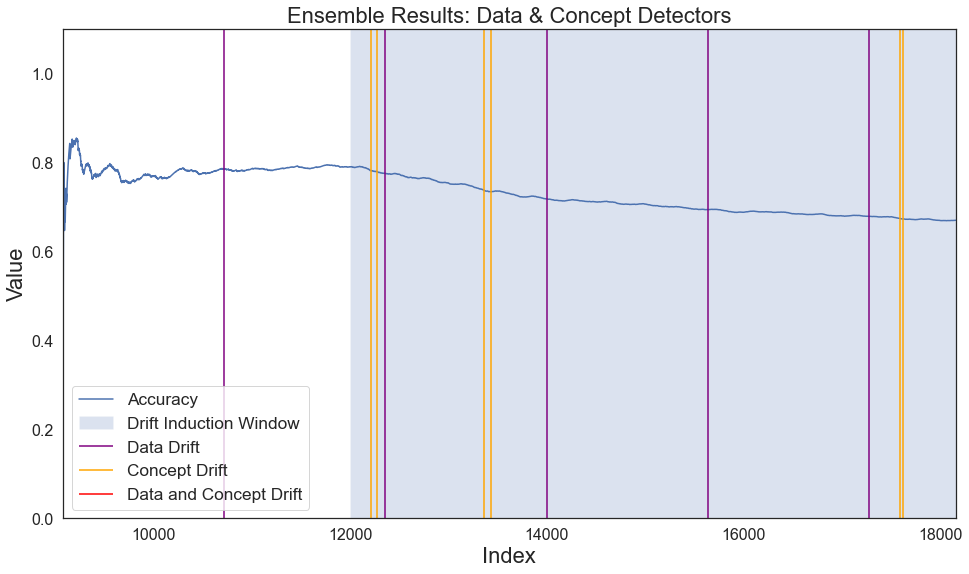

In [23]:
## Plotting ##

status['original_accuracy'] = acc_orig

plt.figure(figsize=(16, 9))
plt.plot("index", "original_accuracy", data=status, 
     label="Accuracy")
#plt.plot("index", "accuracy", data=status, 
#     label="Retrain Accuracy")
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Ensemble Results: Data & Concept Detectors", fontsize=22)
plt.ylabel("Value", fontsize=22)
plt.xlabel("Index", fontsize=22)
ylims = [0, 1.1]
plt.ylim(ylims)
plt.xlim([len(X_train), len(df)])
plt.axvspan(12000, len(df), alpha=0.2, label="Drift Induction Window")

# Draw yellow lines that indicate where data drift was detected
plt.vlines(
     x=status.loc[status["data drift"] == "drift"]["index"],
     ymin=ylims[0],
     ymax=ylims[1],
     label="Data Drift",
     color="purple",
)
# Draw orange lines that indicate where concept drift was detected
plt.vlines(
     x=status.loc[status["concept drift"] == "drift"]["index"],
     ymin=ylims[0],
     ymax=ylims[1],
     label="Concept Drift",
     color="orange",
)


plt.legend(loc='lower left', fontsize='x-large')
plt.show()

### Combining Data Detectors

In [18]:
from menelaus.data_drift.cdbd import CDBD

example_data = make_example_batch_data()

# initialize set of detectors with desired parameterizations
detectors = {
    'k1': KdqTreeBatch(bootstrap_samples=500),
    'h1': HDDDM(subsets = 10, divergence = "KL"),
    'h2': HDDDM(subsets = 10),
    'c': CDBD()
}

# Specify features (cdbd is univariate, kdqtree only monitors continuous features )
column_selectors = {
    'k1': lambda x: x[['a','b','c','d','e','f','g','h','i','j']],
    'h1': lambda x: x,
    'h2': lambda x: x,
    'c': lambda x: x[['confidence']]
}

# Choose an election scheme
election = MinimumApprovalElection(approvals_needed=1)

# initialize an ensemble object
ensemble = BatchEnsemble(detectors, election, column_selectors)

# split dataset into 1 dataset for each 'batch' (year)
df_into_batches = [x for _,x in example_data.groupby('year')]

# batch detectors -- and ensembles -- need an initial reference batch
init_year = example_data.iloc[0,0]
ensemble.set_reference(df_into_batches[0].iloc[:,1:-1])

status = pd.DataFrame(columns=["year", "drift","total","detector_list"])

for i, batch in enumerate(df_into_batches[1:]):

    # Reset det monitors 
    total = 0 
    drift_list = []

    # Update ensemble 
    ensemble.update(batch.iloc[:,1:-1])

    if ensemble.drift_state is not None: 

        # Store results of individual detector 
        for det in ensemble.drift_state_dict.keys():
            if ensemble.drift_state_dict[det] == 'drift':
                drift_list.append(det)
                total += 1
                
    # Store results 
    status.loc[i] = [init_year + i, ensemble.drift_state, total, drift_list]



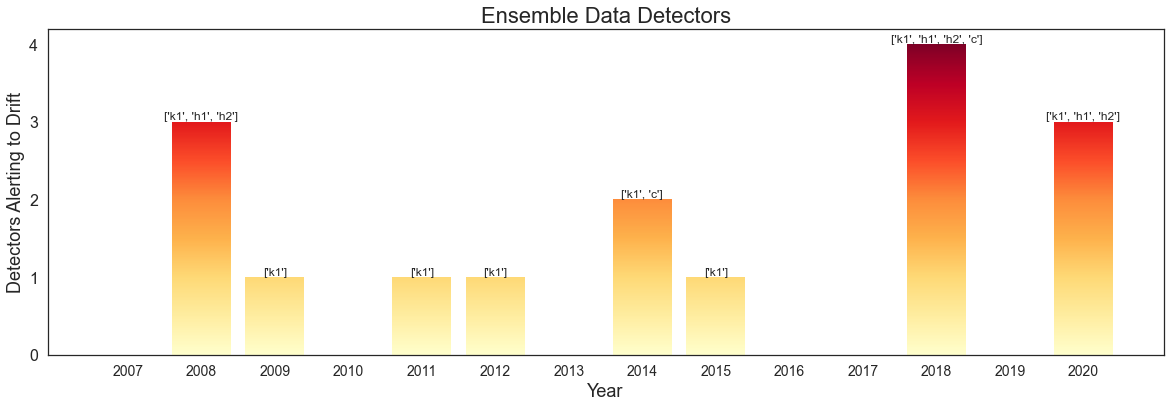

In [19]:
#Gradient Color Bar Plots
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors as mcolors, path

def gradientbars(bars,ydata,cmap):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    ax.axis(lim)
    for bar in bars:
        bar.set_facecolor("none")
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.atleast_2d(np.linspace(0,1*h/max(ydata),256)).T
        #zorder of 2 to get gradients above the facecolor, but below the bar outlines
        ax.imshow(grad, extent=[x,x+w,y,y+h], origin='lower',aspect="auto",zorder=2, norm=cm.colors.NoNorm(vmin=0,vmax=1),cmap=plt.get_cmap(cmap))

fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("white")
plt.grid(False, axis="x")
plt.xticks(status.year.unique(),fontsize=14)
plt.yticks((0,1, 2, 3, 4,), fontsize=16)
plt.title("Ensemble Data Detectors", fontsize=22)
plt.ylabel("Detectors Alerting to Drift", fontsize=18)
plt.xlabel("Year", fontsize=18)
my_bar = ax.bar(status.year,status.total)
gradientbars(my_bar, status.total, 'YlOrRd')
for x, y, p in zip(status["year"],status["total"],status["detector_list"]):
   if y > 0:
      plt.text(x, y, p,  ha='center', va = 'bottom')
plt.show()